#### Загрузка набора данных и библиотек для EDA

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/sdwpf_2001_2112_full.csv')
df.columns
df = df.sort_values(by=['TurbID', 'Tmstamp']).reset_index(drop=True)

Index(['TurbID', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1',
       'Pab2', 'Pab3', 'Prtv', 'T2m', 'Sp', 'RelH', 'Wspd_w', 'Wdir_w', 'Tp',
       'Patv'],
      dtype='object')

#### Заполнение пустых значений

In [22]:
round(df_interpolated.isna().sum() / len(df_interpolated), 2)

TurbID     0.0
Tmstamp    0.0
Wspd       0.0
Wdir       0.0
Etmp       0.0
Itmp       0.0
Ndir       0.0
Pab1       0.0
Pab2       0.0
Pab3       0.0
Prtv       0.0
T2m        0.0
Sp         0.0
RelH       0.0
Wspd_w     0.0
Wdir_w     0.0
Tp         0.0
Patv       0.0
dtype: float64

In [23]:
df_interpolated = df.interpolate(method='linear', limit_direction='both')

C:\Users\vsu70\AppData\Local\Temp\ipykernel_15144\4206821247.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear', limit_direction='both')


#### Удаление записей с пропусками (альтернатива)

In [32]:
# df2 = df[['TurbID', 'Tmstamp', 'Wspd','Wdir', 'Etmp', 'Patv']]
features = df.columns.drop(['TurbID', 'Tmstamp'])
mask = df.isna().any(axis=1)
bad_timestamps = df.loc[mask, 'Tmstamp']
df_interpolated = df[~df['Tmstamp'].isin(bad_timestamps)]

#### График распределения

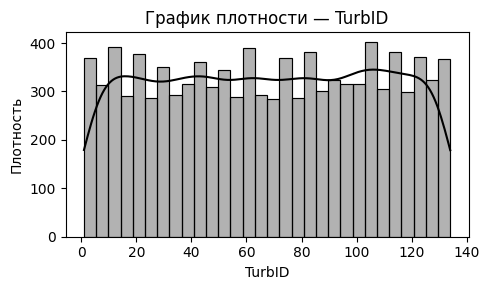

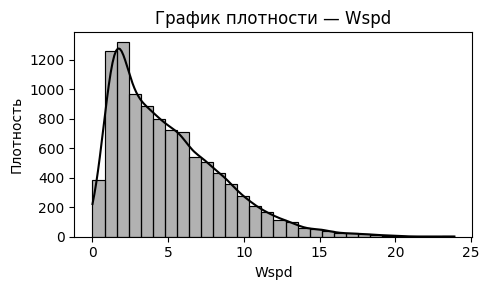

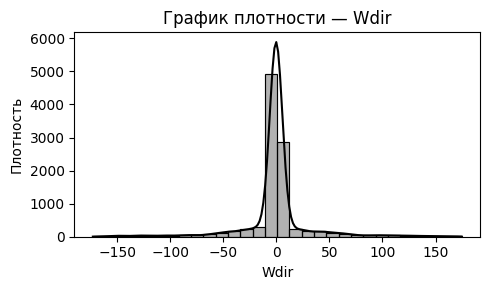

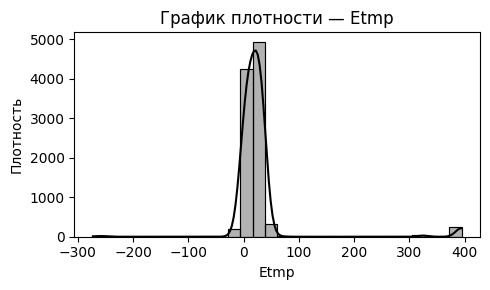

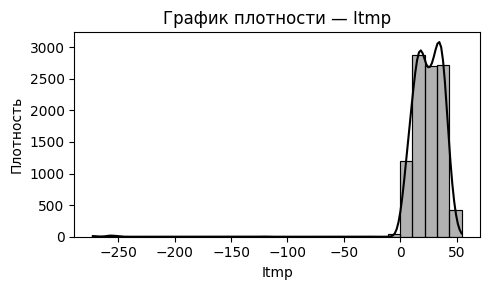

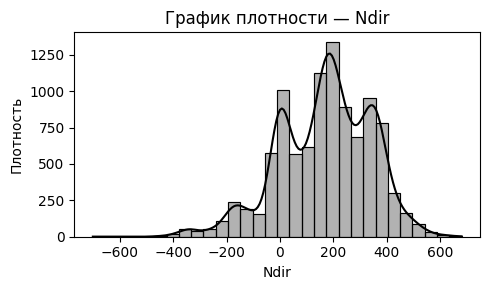

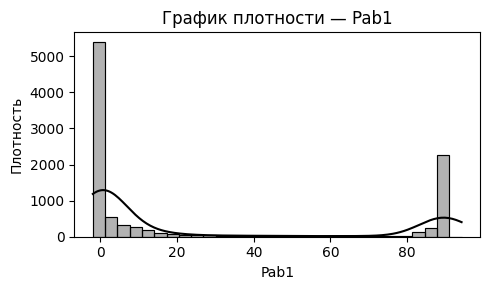

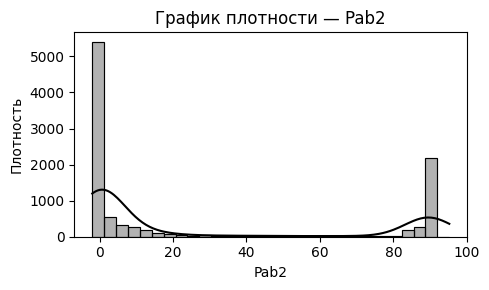

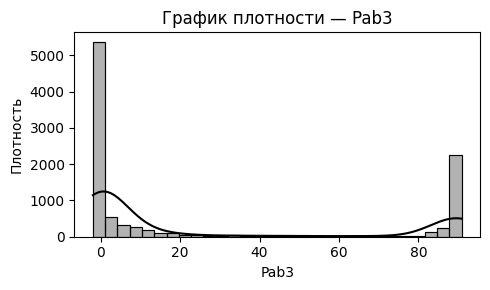

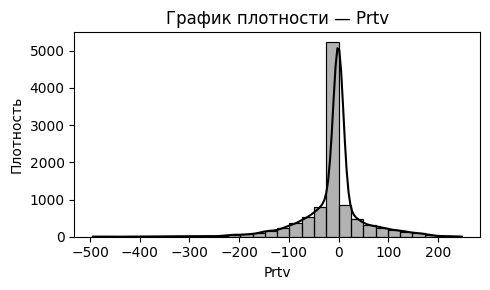

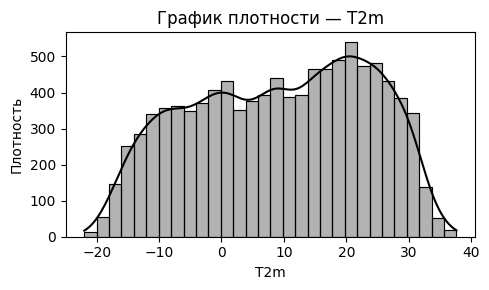

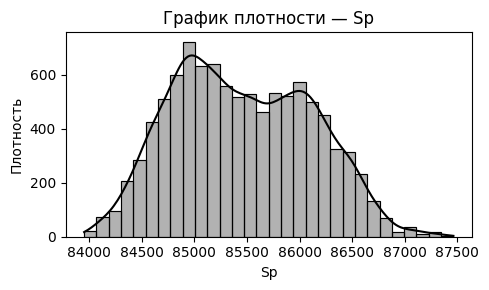

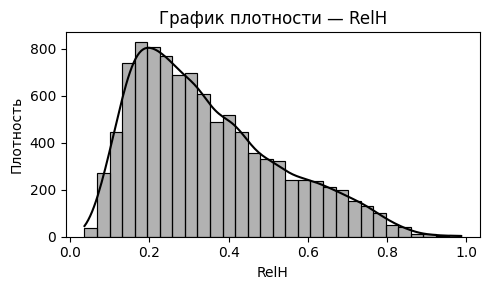

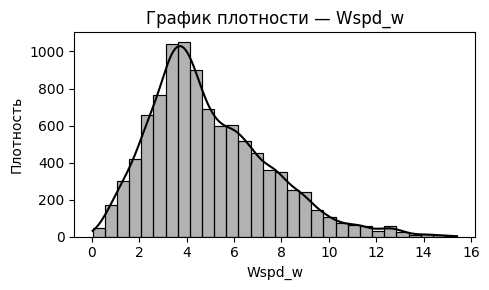

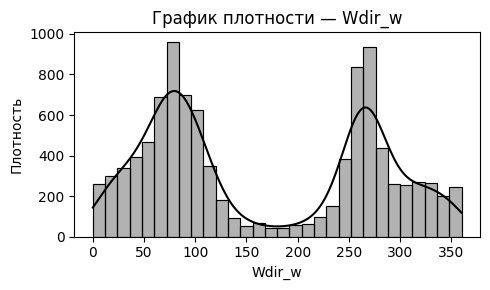

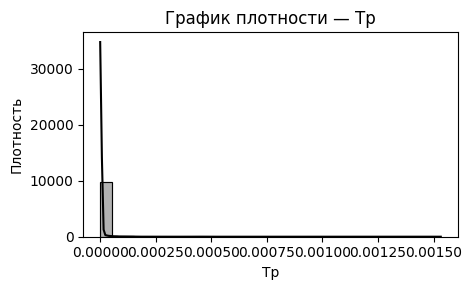

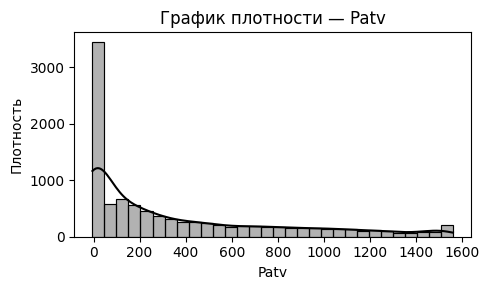

In [67]:
for column in df_cleaned.select_dtypes(include='number').columns:
    plt.figure(figsize=(5, 3))
    sample_data = df_interpolated[column].sample(n=10000, random_state=42)
    # sample_data.plot.box()
    sns.histplot(sample_data, kde=True, bins=30, edgecolor='black', alpha=0.3, color='black')
    plt.title(f'График плотности — {column}')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.tight_layout()
    plt.show()


#### График сезонности

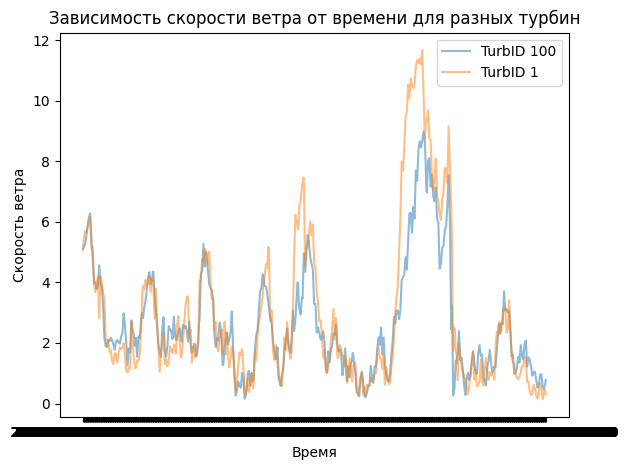

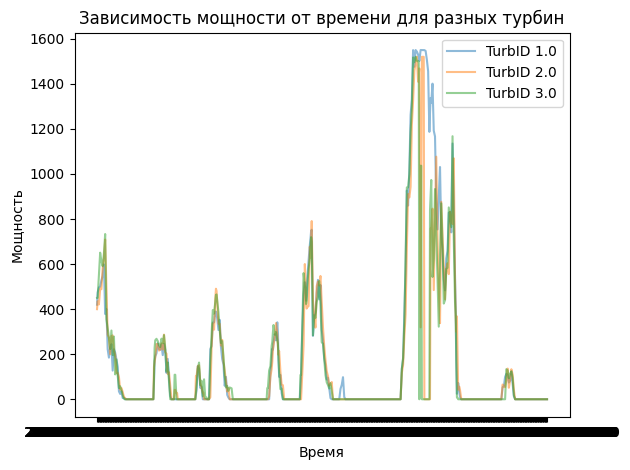

In [63]:
plt.plot()

for turb_id in [100, 1]:
# for turb_id in df_cleaned['TurbID'].unique()[100:102]:
    subset = df_cleaned[df_cleaned['TurbID'] == turb_id][:720]
    plt.plot(subset['Tmstamp'], subset['Wspd'], label=f'TurbID {turb_id}', alpha=0.5)

plt.xlabel('Время')
plt.ylabel('Скорость ветра')
plt.title('Зависимость скорости ветра от времени для разных турбин')
plt.legend()
plt.tight_layout() 
plt.show()

plt.plot()

for turb_id in df_cleaned['TurbID'].unique()[:3]:
    subset = df_cleaned[df_cleaned['TurbID'] == turb_id][:720]
    plt.plot(subset['Tmstamp'], subset['Patv'], label=f'TurbID {turb_id}', alpha=0.5)

plt.xlabel('Время')
plt.ylabel('Мощность')
plt.title('Зависимость мощности от времени для разных турбин')
plt.legend()
plt.tight_layout() 
plt.show()


#### Устранение выбросов

In [33]:
def iqr_cleaner(df_with_outliers):
    df_cleaned = df_with_outliers.copy()
    for column in df_with_outliers.select_dtypes(include='number').columns:
        Q1 = df_with_outliers[column].quantile(0.25)
        Q3 = df_with_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_with_outliers[(df_with_outliers[column] < lower_bound) | (df_with_outliers[column] > upper_bound)]
        if column != 'Wdir':
            df_cleaned[column] = np.where(df_with_outliers[column] > upper_bound, upper_bound, df_with_outliers[column])
            df_cleaned[column] = np.where(df_with_outliers[column] < lower_bound, lower_bound, df_with_outliers[column])
        print(column, round(len(outliers) / len(df_with_outliers), 2))
        
    df_cleaned['Patv'] = np.where(df_with_outliers['Patv'] < 0, 0, df_with_outliers['Patv'])
    df_cleaned['Prtv'] = np.where(df_with_outliers['Prtv'] < 0, 0, df_with_outliers['Prtv'])
    return df_cleaned

df_cleaned = iqr_cleaner(df_interpolated)

TurbID 0.0
Wspd 0.02
Wdir 0.22
Etmp 0.03
Itmp 0.0
Ndir 0.01
Pab1 0.0
Pab2 0.0
Pab3 0.0
Prtv 0.28
T2m 0.0
Sp 0.0
RelH 0.0
Wspd_w 0.02
Wdir_w 0.0
Tp 0.06
Patv 0.03


#### График корреляции переменных

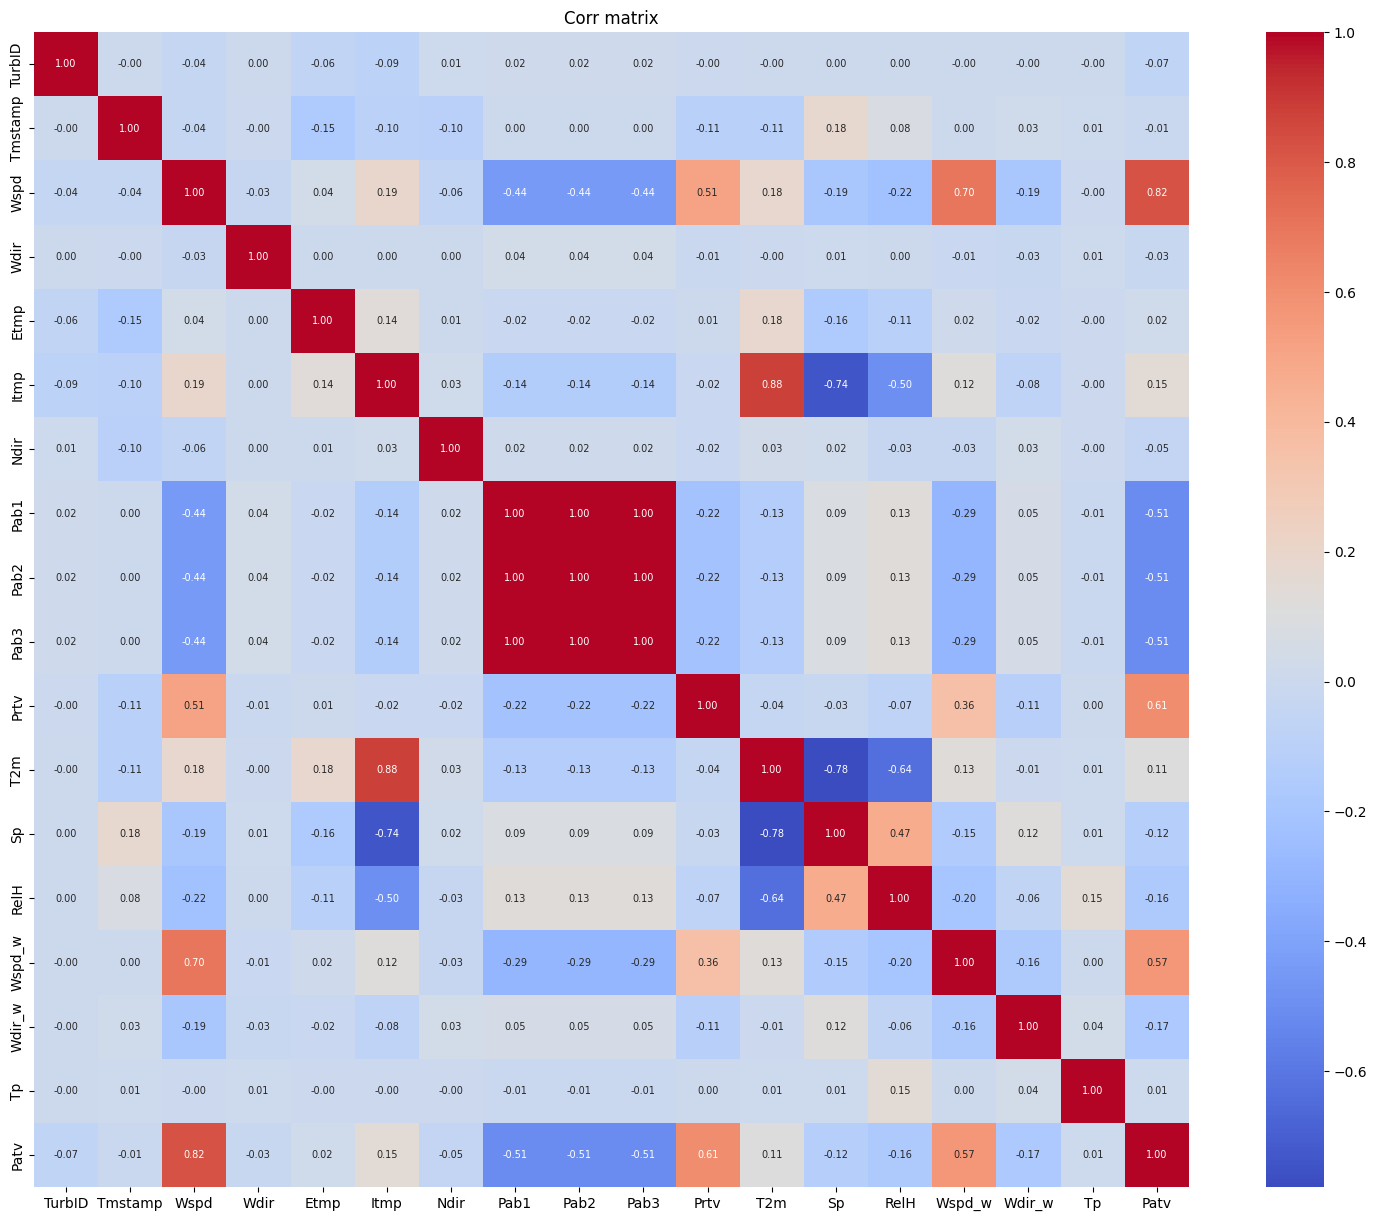

In [65]:
df_cleaned['Tmstamp'] = pd.to_datetime(df_cleaned['Tmstamp'])
corr_matrix = df_cleaned.corr()
plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True,
            annot_kws={"size": 7})
plt.title('Corr matrix')
plt.savefig("plot.png")
plt.show()

In [ ]:
from scipy.stats import zscore


for column in df2.select_dtypes(include='number').columns:
    z_scores = zscore(df2[column])
    outliers_mask = (z_scores > 1.5) | (z_scores < -1.5)
    outliers_count = outliers_mask.sum()
    print(column, round(outliers_count / len(df2), 2))

#### Нормализация данных

In [35]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
df_scaled = df_cleaned.copy()

features = df_cleaned.columns.drop(['TurbID', 'Tmstamp', 'Patv'])
df_scaled[features] = scaler.fit_transform(df_cleaned[features])

#### Построение матрицы связей

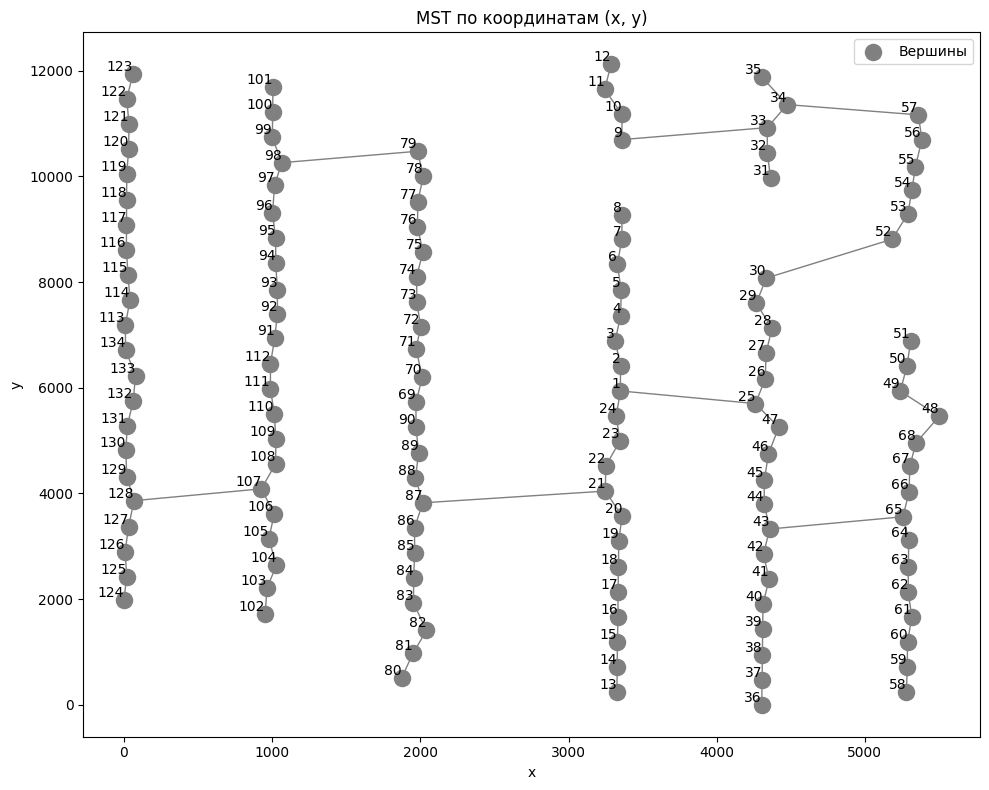

In [82]:
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree


turb_location = pd.read_csv('../data/sdwpf_turb_location_elevation.csv')
ids = turb_location['TurbID'].values
idx_map = {vid: i for i, vid in enumerate(ids)}

coords = turb_location[['x', 'y', 'Ele']].values
flat_coords = turb_location[['x', 'y']].values
dist_matrix = cdist(coords, coords, metric='euclidean')

mst_sparse = minimum_spanning_tree(dist_matrix)
mst_matrix = mst_sparse.toarray()
mst_matrix = mst_matrix + mst_matrix.T

# Визуализация графа
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], color='gray', s=134, label='Вершины')

for i, (x, y) in enumerate(flat_coords):
    plt.text(x, y, str(ids[i]), fontsize=10, ha='right', va='bottom')

for i in range(len(flat_coords)):
    for j in range(i + 1, len(flat_coords)):  # Только верхний треугольник, так как матрица симметрична
        if mst_matrix[i, j] > 0:
            x_values = [flat_coords[i, 0], flat_coords[j, 0]]
            y_values = [flat_coords[i, 1], flat_coords[j, 1]]
            plt.plot(x_values, y_values, color='gray', linewidth=1)

plt.title('MST по координатам (x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

#### Обучение модели

In [ ]:
turbine_data = []
features_with_patv = list(features) + ['Patv']

for turb_id, group in df_scaled.groupby('TurbID'):
    arr = group[features_with_patv].values.T
    turbine_data.append(arr)

result_array = np.stack(turbine_data)
result_array = result_array.astype(np.float32)[:, :, :1000]
print(result_array.shape)

(134, 16, 1000)


Epoch 1/10, Train Loss: 31965.8639, Val Loss: 2160.4108
Sample 0, Node 0 — True: [0.], Pred: [10.976376]
Sample 1, Node 0 — True: [0.], Pred: [10.968593]
Epoch 2/10, Train Loss: 13062.5856, Val Loss: 309.7656
Sample 0, Node 0 — True: [0.], Pred: [0.90467465]
Sample 1, Node 0 — True: [0.], Pred: [0.9220358]
Epoch 3/10, Train Loss: 8614.8097, Val Loss: 232.5343
Sample 0, Node 0 — True: [0.], Pred: [-0.00537924]
Sample 1, Node 0 — True: [0.], Pred: [-0.00091537]
Epoch 4/10, Train Loss: 7303.1375, Val Loss: 399.0989
Sample 0, Node 0 — True: [0.], Pred: [0.21960852]
Sample 1, Node 0 — True: [0.], Pred: [0.22114566]
Epoch 5/10, Train Loss: 6792.2774, Val Loss: 206.3283
Sample 0, Node 0 — True: [0.], Pred: [1.6682247]
Sample 1, Node 0 — True: [0.], Pred: [1.6717119]
Epoch 6/10, Train Loss: 6236.8600, Val Loss: 177.4973
Sample 0, Node 0 — True: [0.], Pred: [0.6786589]
Sample 1, Node 0 — True: [0.], Pred: [0.68604296]
Epoch 7/10, Train Loss: 5738.7420, Val Loss: 172.6298
Sample 0, Node 0 — True

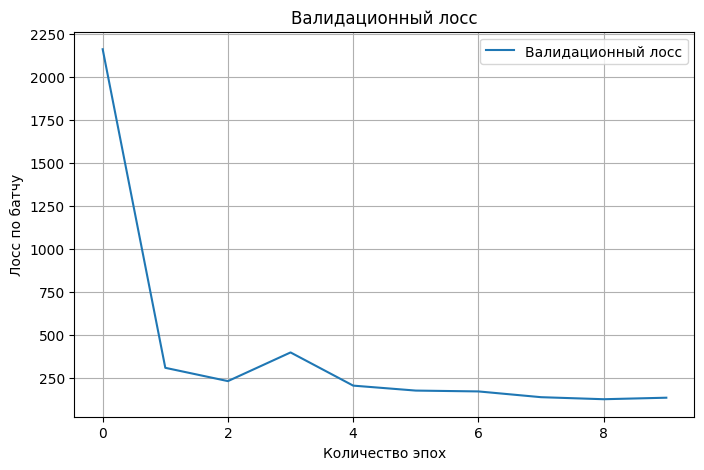

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from net import gtnet

# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(mst_matrix, dtype=torch.float32, device=device)
num_nodes = 134
in_dim = 16
seq_length = 10
out_dim = 1
batch_size = 32
epochs = 10
learning_rate = 0.001
buildA_true = False

np.random.seed(42)
data = result_array


# Разбиваем на обучающие примеры
def create_dataset(data, seq_len, pred_len):
    x_list, y_list = [], []
    for t in range(data.shape[2] - seq_len - pred_len + 1):
        x = data[:, :, t:t+seq_len]             # (nodes=134, feats=16, seq=14)
        x_list.append(x.transpose(1, 0, 2))     # -> (16,134,14)

        # Y: только последняя фича за 2 шага
        y = data[:, -1, t+seq_len : t+seq_len+pred_len]  # (134,2)
        y = y[None, :, :]                                # (1,134,2)
        y_list.append(y)                                 # без дополнительной транспозиции!
    
    # Собираем батчи
    X = np.stack(x_list, axis=0)  # -> (N,16,134,14)
    Y = np.stack(y_list, axis=0)  # -> (N,1,134,2)
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float()

X, Y = create_dataset(data, seq_length, out_dim)
# print("Dataset shape:", X.shape, Y.shape)

# Разделение на train/test (80%/20%)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# DataLoader'ы
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Инициализация модели
model = gtnet(
    gcn_true=True,
    buildA_true=buildA_true,
    predefined_A=A,
    gcn_depth=2,
    num_nodes=num_nodes,
    device=device,
    dropout=0.1,
    subgraph_size=5,
    node_dim=10,
    dilation_exponential=2,
    conv_channels=32,
    residual_channels=32,
    skip_channels=64,
    end_channels=128,
    seq_length=seq_length,
    in_dim=in_dim,
    out_dim=out_dim,
    layers=3
).to(device)


# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Цикл обучения с валидацией
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        out = model(batch_x.to(device))      # [B, 2, 134, 1]
        pred = out.squeeze(-1)               # [B, 2, 134]

        # Подготовка target
        target = batch_y.to(device)          # [B, 1, 134, 2]
        target = target.squeeze(1)           # -> [B, 134, 2]
        target = target.permute(0, 2, 1)     # -> [B, 2, 134]

        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Валидация
    model.eval()
    val_loss = 0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)      # [B,16,134,14]
            batch_y = batch_y.to(device)      # [B,1,134,2]

            # Прямой проход
            out    = model(batch_x)           # [B,2,134,1]
            pred   = out.squeeze(-1)          # [B,2,134]

            # Подготовка таргета
            target = batch_y.squeeze(1)       # [B,134,2]
            target = target.permute(0, 2, 1)  # [B,2,134]

            # Считаем лосс
            loss = loss_fn(pred, target)
            val_loss += loss.item()

            # Сохраняем результаты на CPU
            all_preds.append(pred.cpu().numpy())    # каждый элемент shape [B,2,134]
            all_trues.append(target.cpu().numpy())  # каждый элемент shape [B,2,134]

    # После цикла объединяем по batch-оси
    all_preds = np.concatenate(all_preds, axis=0)  # теперь shape [N,2,134]
    all_trues = np.concatenate(all_trues, axis=0)  # теперь shape [N,2,134]

    print(f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {total_loss / len(train_loader):.4f}, "
        f"Val Loss: {val_loss / len(test_loader):.4f}")
    
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))

    # Теперь all_preds и all_trues — это массивы, и мы можем их индексировать
    for i in range(2):
        true_vals = all_trues[i, :, 0]  # shape=(2,)
        pred_vals = all_preds[i, :, 0]  # shape=(2,)
        print(f"Sample {i}, Node 0 — True: {true_vals}, Pred: {pred_vals}")

plt.figure(figsize=(8, 5))
plt.plot(val_losses, label='Валидационный лосс')
plt.xlabel('Количество эпох')
plt.ylabel('Лосс по батчу')
plt.title('Валидационный лосс')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import torch

if torch.cuda.is_available():
    print("GPU доступна!")
    print(f"Название GPU: {torch.cuda.get_device_name(0)}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
else:
    print("GPU не доступна, используется CPU")

GPU доступна!
Название GPU: NVIDIA GeForce GTX 1070 Ti
Количество GPU: 1


In [2]:
import torch

print(torch.__version__)
print("CUDA доступен:", torch.cuda.is_available())
print("Версия CUDA:", torch.version.cuda)

2.7.0+cu126
CUDA доступен: True
Версия CUDA: 12.6
